## 11. AGN HOD modelling
This notebook studies the propoerties of the new mock AGN catalogues that accounts for close pairs fraction of AGN.

1. Loading data and defining input parameters

**Script written by**: Soumya Shreeram <br>
**Project supervised by**: Johan Comparat <br>
**Date**: 21st July 2021

In [1]:
# astropy modules
import astropy.units as u
import astropy.io.fits as fits

from astropy.table import Table, Column, join
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM, z_at_value

import numpy as np

# system imports
import os
import sys
import importlib as ib
import glob

# plotting imports
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

from scipy.stats import norm
from scipy import interpolate
import pandas as pd

Set plot properties and load personal imports

In [2]:
%matplotlib inline
font = {'family' : 'serif',
        'weight' : 'medium',
        'size'   : 20}
matplotlib.rc('font', **font)

sys.path.append('../imported_files/')
import Exploring_DM_Halos as edh
import Agn_incidence_from_Major_Mergers as aimm
import Comparison_simulation_with_literature_data as cswl
import Scaling_relations as sr
import plotting_sr_agn_clu as pt
import All_sky as sky
import HOD_final_tests as hod

### 1. Loading relavant data

In [3]:
# pixel number from the simulation file
pixel_no_cont_arr = sky.allPixelNames()

# pixel number from the simulation file
pixel_no = '000000'
redshift_limit = 2

pal = sns.hls_palette(10, h=.5, s=1).as_hex()
sns.set_context("paper", font_scale=2, rc={"lines.linewidth":2})

 # fraction of close pair agns added to the cat_AGN_all
frac_cp_arr = [0.03, 0.10, 0.15, 0.20]

# for testing purposes use this frac_cp
frac_cp = 0.2

m_bins, z_bins = np.arange(11.4, 15.5, 0.1), np.arange(0, 6.2, 0.1)
cut_columns = np.where(z_bins<= redshift_limit)

m_mid, z_mid = (m_bins[1:]+m_bins[:-1])/2, (z_bins[1:]+z_bins[:-1])/2

# boolean that decides wether of not to concat the hist files
concat_HIST = True
concat_HIST_gal = True
concat_HIST_agn = True

####  Set/load directory paths

In [4]:
# set data dir path
data_dir = os.path.join('/data24s', 'comparat', 'simulation', 'UNIT', 'ROCKSTAR_HALOS',\
         'fixedAmp_InvPhase_001')
string = '%.1f'%frac_cp

# arr to get the different cp catAGN directories
tmm_start_vals = [1.2, 2.3, 3.7, 0.6]
model_names_arr_all, list_model_names_all = np.zeros((0, 4)),  np.zeros((0, 4))

for model_no in np.arange(4):
    filenames = 'CP_10_sigma_1.0_frac_*_%.1f_tmm_*_*_xoff_*'%tmm_start_vals[model_no]
    list_model_names = np.array(glob.glob(os.path.join(data_dir,filenames)))
    list_model_names_all = np.append(list_model_names_all, [list_model_names], axis=0)
    
    
    # arr to save the different cases of CP catAGN 
    model_names_arr = ['Model_A%d_frac_%.2f'%(model_no, frac) for frac in frac_cp_arr]
    model_names_arr_all = np.append(model_names_arr_all, [model_names_arr], axis=0)
# arr for the galaxy dir
gal_dir = os.path.join(data_dir, 'cat_GALAXY_all')

# agn dir that contains the HIST files
agn_dir = os.path.join(data_dir, 'WTH_fsat_10_sigma_1.0')

# saving information locally
save_dir = '../Data/pairs_z%.1f/HOD/'%redshift_limit

In [5]:
model_names_arr

['Model_A3_frac_0.03',
 'Model_A3_frac_0.10',
 'Model_A3_frac_0.15',
 'Model_A3_frac_0.20']

In [6]:
path = glob.glob(os.path.join(data_dir, 'CP_10_sigma_1.0_frac_' + string + '_%.1f_tmm_*_*_xoff_*'%tmm_start_vals[model_no] ))[0]
print(path)
os.path.isdir(path)

/data24s/comparat/simulation/UNIT/ROCKSTAR_HALOS/fixedAmp_InvPhase_001/CP_10_sigma_1.0_frac_0.2_0.6_tmm_1.2_0.07_xoff_0.09


True

Load the CP AGN catalogue file for a given pixel

In [7]:
hd_catCP = hod.loadCPcatAGN(pixel_no=pixel_no, frac_cp=frac_cp)

Saving/loading the concatenated hist files for the different AGN models

In [25]:
ib.reload(hod)
for idx in [1, 2, 3]:
    for Lmin, Zmax in zip([42, 43, 44], [0.2, 0.4, 1.1]):
        concat_HIST_LminZmax = True
        if concat_HIST_LminZmax:
            hod.concatAllPixelsLminZmax(cut_columns, list_model_names_all[idx], save_dir,\
                                        model_names_arr_all[idx], Lmin, Zmax, catGal=False)

In [8]:
def loadHODFiles(Lmin, Zmax, model_names_arr_all, cen_histAGN_ALL, histAGN_ALL):
    "Function to get the halo file for every lxmin zmax cut"
    for i, model_names_arr in enumerate(model_names_arr_all):
        filename = '_LX_%d_Z_%.1f'%(Lmin, Zmax)

        for m, model_name in enumerate(model_names_arr):
            cen_histAGN = np.load(save_dir+'cenHIST_'+model_name+filename+'.npy', allow_pickle=True)
            histAGN = np.load(save_dir+'HIST_'+model_name+filename+'.npy', allow_pickle=True)

            cen_histAGN_ALL[i, m] = np.sum(cen_histAGN, axis=0)
            histAGN_ALL[i, m] = np.sum(histAGN, axis=0)
    print(cen_histAGN_ALL.shape, histAGN_ALL.shape)
    return cen_histAGN_ALL, histAGN_ALL

In [9]:
cen_histAGN_ALL = np.zeros((len(model_names_arr), len(model_names_arr), len(m_mid), len(z_bins[cut_columns])))
histAGN_ALL = np.zeros((len(model_names_arr), len(model_names_arr), len(m_mid), len(z_bins[cut_columns])))

cen_histAGN_ALL_L42, histAGN_ALL_L42 =loadHODFiles(42, 0.2, model_names_arr_all, cen_histAGN_ALL, histAGN_ALL)
cen_histAGN_ALL_L43, histAGN_ALL_L43 =loadHODFiles(43, 0.4, model_names_arr_all, cen_histAGN_ALL, histAGN_ALL)
cen_histAGN_ALL_L44, histAGN_ALL_L44 =loadHODFiles(44, 1.1, model_names_arr_all, cen_histAGN_ALL, histAGN_ALL)

(4, 4, 40, 21) (4, 4, 40, 21)
(4, 4, 40, 21) (4, 4, 40, 21)
(4, 4, 40, 21) (4, 4, 40, 21)


In [10]:
concat_HIST = False
ib.reload(hod)
if concat_HIST:
    hod.concatAllPixels(cut_columns, list_model_names, save_dir, model_names_arr)
else:
    cen_histAGN_ALL = np.zeros((len(model_names_arr), len(model_names_arr), len(m_mid), len(z_bins[cut_columns])))
    histAGN_ALL = np.zeros((len(model_names_arr), len(model_names_arr), len(m_mid), len(z_bins[cut_columns])))
    
    for i, model_names_arr in enumerate(model_names_arr_all):
        for m, model_name in enumerate(model_names_arr):
            cen_histAGN = np.load(save_dir+'cenHIST_'+model_name+'.npy', allow_pickle=True)
            histAGN = np.load(save_dir+'HIST_'+model_name+'.npy', allow_pickle=True)

            cen_histAGN_ALL[i, m] = np.sum(cen_histAGN, axis=0)
            histAGN_ALL[i, m] = np.sum(histAGN, axis=0)
    print(cen_histAGN_ALL.shape, histAGN_ALL.shape)

(4, 4, 40, 21) (4, 4, 40, 21)


Saving/Loading the concatenated hist files for the GALAXY catalog

In [11]:
concat_HIST_gal = False
if concat_HIST_gal:
    cen_histGAL = hod.concatHISTallPIX(gal_dir, cut_columns, catGal=True)
    np.save(save_dir+'cenHIST_gal.npy', cen_histGAL, allow_pickle=True)
else:
    cen_histGAL_not_summed = np.load(save_dir+'cenHIST_gal.npy', allow_pickle=True)
    cen_histGAL = np.sum(cen_histGAL_not_summed, axis=0)

In [12]:
cen_histGAL.shape

(40, 21)

In [13]:
concat_HIST_agn = False
ib.reload(hod)
if concat_HIST_agn:
    cen_histAGN, histAGN = hod.concatHISTallPIX(agn_dir, cut_columns)
    np.save(save_dir+'cenHIST_agn.npy', cen_histAGN, allow_pickle=True)
    np.save(save_dir+'HIST_agn.npy', histAGN, allow_pickle=True)
else:
    cen_histAGN_not_summed = np.load(save_dir+'cenHIST_agn.npy', allow_pickle=True)
    histAGN_not_summed = np.load(save_dir+'HIST_agn.npy', allow_pickle=True)
    
    cen_histAGN = np.sum(cen_histAGN_not_summed, axis=0)
    histAGN = np.sum(histAGN_not_summed, axis=0)
print(cen_histAGN.shape)
print(histAGN.shape)

(40, 21)
(40, 21)


Get the histogram for the AGN models

In [14]:
cosmo = FlatLambdaCDM(H0=67.77*u.km/u.s/u.Mpc, Om0=0.307115)
h = 0.6777
L_box = 1000.0 / h

vol = cosmo.comoving_volume(redshift_limit)*(53)/(129600/np.pi)

#Loding the halo file
hd_agn, hd_halo, _ = edh.getHeaders(pixel_no, np.array(['agn', 'halo']))
hd_agn = hd_agn[hd_agn['redshift_R']<redshift_limit]
hd_halo = hd_halo[hd_halo['redshift_R']<redshift_limit]

model_no = 1
zz = 0
f = 3

### 2. Plot 1-Halo distributions

In [15]:
def plotForAllZbins(ax, m_mid, cenN, color, ls='-', label=''):
    # plot the lines for every z-bin
    ax.plot(10**m_mid, cenN, ls=ls, color=color, lw=1.5, label=label)
    return ax

In [14]:
np.where((cen_histAGN[0, :]/cen_histGAL[0, :])>0.001)

(array([0]),)

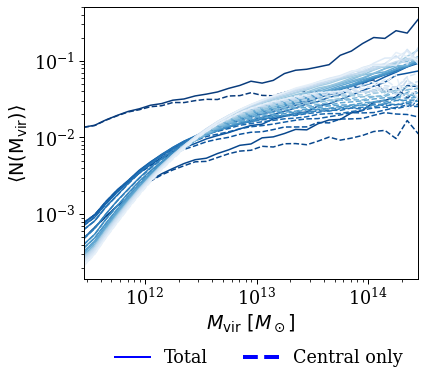

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
blues = sns.color_palette("Blues_r", cen_histGAL.shape[1]+1)
greys = sns.color_palette("Greys", cen_histGAL.shape[1]+1)
stop_m = 9
for i in range(cen_histGAL.shape[1]):
    ax = plotForAllZbins(ax, m_mid[:-stop_m],\
                         (cen_histAGN[:-stop_m, i]/cen_histGAL[:-stop_m, i]),\
                         blues[i], label='Galaxies', ls='--')
    ax = plotForAllZbins(ax, m_mid[:-stop_m], (histAGN[:-stop_m, i]/cen_histGAL[:-stop_m, i]), blues[i], label='Galaxies')
ax.set_yscale('log')
ax.set_xscale('log')
fig.patch.set_facecolor('white')
pt.setLabel(ax, r'$M_{\rm vir}\ [M_\odot]$', r'$\langle \rm N(M_{\rm vir}) \rangle$',\
            legend=False, xlim=[10**np.min(m_mid), 10**np.max(m_mid[:-stop_m])])
pt.saveFig('HOD_AGN_only.png')
custom_lines = [Line2D([0], [0], color='b', lw=2, ls='-'),
                Line2D([0], [0], color='b', lw=4, ls='--')]
ax.legend(custom_lines, ['Total', 'Central only'], bbox_to_anchor=(1, -0.2), frameon=False, ncol=2)

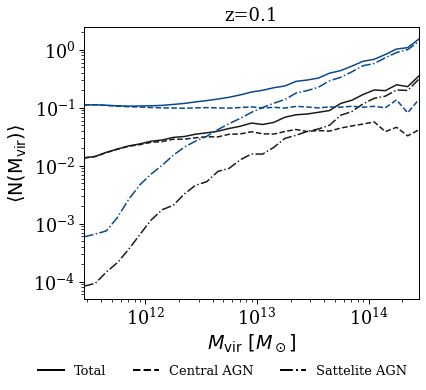

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
blues = sns.color_palette("Blues", cen_histGAL.shape[1]+1)
greys = sns.color_palette("Greys", cen_histGAL.shape[1]+1)
stop_m = 9
model_no=3
f = 0

# cen models
"""
ax = plotForAllZbins(ax, m_mid[:-stop_m],\
                     (cen_histAGN_ALL[model_no, f, :-stop_m, zz]/cen_histGAL[:-stop_m, i]), \
                     blues[i], label='Galaxies', ls='--')

"""

# cen no models
ax = plotForAllZbins(ax, m_mid[:-stop_m],\
                         (cen_histAGN[:-stop_m, zz]/cen_histGAL[:-stop_m, zz]),\
                         greys[i], ls='--')


# sat no models
sat_AGN_no_model = histAGN[:-stop_m, zz]-cen_histAGN[:-stop_m, zz]
ax = plotForAllZbins(ax, m_mid[:-stop_m],\
                         (sat_AGN_no_model/cen_histGAL[:-stop_m, zz]),\
                         greys[i], ls='-.')

# total no models
ax = plotForAllZbins(ax, m_mid[:-stop_m],\
                         (histAGN[:-stop_m, zz]/cen_histGAL[:-stop_m, zz]),\
                         greys[i], ls='-')



# cen models
ax = plotForAllZbins(ax, m_mid[:-stop_m],\
                     (cen_histAGN_ALL[model_no, f, :-stop_m, zz]/cen_histGAL[:-stop_m, zz]),\
                     blues[i], ls='--')

# sat models
sat_AGN_model = histAGN_ALL[model_no, f, :-stop_m, zz]-cen_histAGN_ALL[model_no, f, :-stop_m, zz]
ax = plotForAllZbins(ax, m_mid[:-stop_m],\
                     (sat_AGN_model/cen_histGAL[:-stop_m, zz]), \
                     blues[i], ls='-.')

# total models
ax = plotForAllZbins(ax, m_mid[:-stop_m],\
                     (histAGN_ALL[model_no, f, :-stop_m, zz]/cen_histGAL[:-stop_m, zz]),\
                     blues[i], ls='-')


ax.set_yscale('log')
ax.set_xscale('log')
fig.patch.set_facecolor('white')
t = 'z=%.1f'%z_mid[zz]
pt.setLabel(ax, r'$M_{\rm vir}\ [M_\odot]$', r'$\langle \rm N(M_{\rm vir}) \rangle$',\
            title=t, legend=False, xlim=[10**np.min(m_mid), 10**np.max(m_mid[:-stop_m])])
pt.saveFig('HOD_AGN_only.png')
custom_lines = [Line2D([0], [0], color='k', lw=2, ls='-'),
                Line2D([0], [0], color='k', lw=2, ls='--'),
               Line2D([0], [0], color='k', lw=2, ls='-.')]
ax.legend(custom_lines, ['Total', 'Central AGN', 'Sattelite AGN'], bbox_to_anchor=(1, -0.2), frameon=False, ncol=3, fontsize=13)

0.0


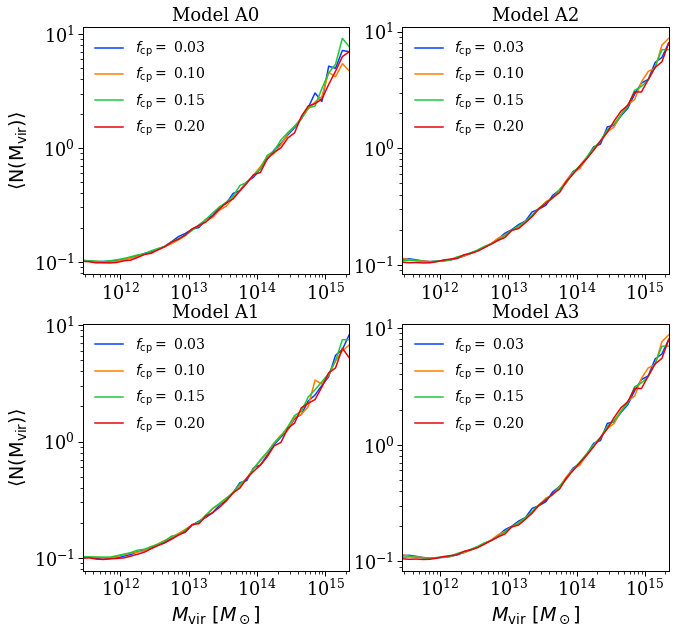

In [77]:
fig, ax = plt.subplots(2, 2, figsize=(10.5, 10 ))
zz = 0
print(z_bins[zz])
color = sns.color_palette("bright", histAGN_ALL.shape[0]+1)#['r', 'b', 'g', 'orange']
#--------------------------------#
model_no = 0
for f in range(len(frac_cp_arr)):
    title, label = 'Model A%d'%model_no, r'$f_{\rm cp}=$ %.2f'%frac_cp_arr[f]
    ax[0, 0] = plotForAllZbins(ax[0,0], m_mid, histAGN_ALL[model_no, f, :, zz]/cen_histGAL[:, zz],\
                         color[f], label=label)
pt.setLabel(ax[0, 0], '', r'$\langle \rm N(M_{\rm vir}) \rangle$', \
            xlim=[10**np.min(m_mid), 10**np.max(m_mid)], title=title)
#--------------------------------#
model_no = 1
for f in range(len(frac_cp_arr)):
    title, label = 'Model A%d'%model_no, r'$f_{\rm cp}=$ %.2f'%frac_cp_arr[f]
    ax[1, 0] = plotForAllZbins(ax[1,0], m_mid, histAGN_ALL[model_no, f, :, zz]/cen_histGAL[:, zz],\
                         color[f], label=label)
pt.setLabel(ax[1, 0], r'$M_{\rm vir}\ [M_\odot]$', r'$\langle \rm N(M_{\rm vir}) \rangle$',\
            xlim=[10**np.min(m_mid), 10**np.max(m_mid)], title=title)
#--------------------------------#
model_no = 2
for f in range(len(frac_cp_arr)):
    title, label = 'Model A%d'%model_no, r'$f_{\rm cp}=$ %.2f'%frac_cp_arr[f]
    ax[0, 1] = plotForAllZbins(ax[0,1], m_mid, histAGN_ALL[model_no, f, :, zz]/cen_histGAL[:, zz],\
                         color[f], label=label)
pt.setLabel(ax[0, 1], '', '',\
            xlim=[10**np.min(m_mid), 10**np.max(m_mid)], title=title)
#--------------------------------#
model_no = 3
for f in range(len(frac_cp_arr)):
    title, label = 'Model A%d'%model_no, r'$f_{\rm cp}=$ %.2f'%frac_cp_arr[f]
    ax[1, 1] = plotForAllZbins(ax[1, 1], m_mid, histAGN_ALL[model_no, f, :, zz]/cen_histGAL[:, zz],\
                         color[f], label=label)
pt.setLabel(ax[1, 1],r'$M_{\rm vir}\ [M_\odot]$', '',\
            xlim=[10**np.min(m_mid), 10**np.max(m_mid)], title=title)

for i, j in zip([0, 0, 1, 1], [0, 1, 0, 1]):
    ax[i, j].set_xscale('log')
    ax[i, j].set_yscale('log')
    
fig.patch.set_facecolor('white')
pt.saveFig('frac_free_models_fixed.png')

0.30000000000000004


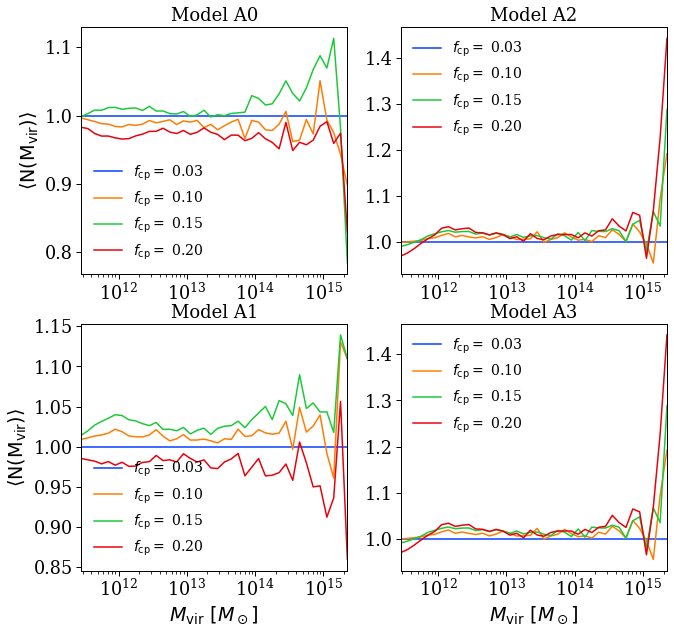

In [45]:
fig, ax = plt.subplots(2, 2, figsize=(10.5, 10 ))
zz = 1
print(z_bins[zz])
color = sns.color_palette("bright", histAGN_ALL.shape[0]+1)#['r', 'b', 'g', 'orange']
#--------------------------------#
model_no = 0
hod0 = histAGN_ALL[model_no, 0, :, zz]/cen_histGAL[:, zz]
    
for f in range(len(frac_cp_arr)):
    title, label = 'Model A%d'%model_no, r'$f_{\rm cp}=$ %.2f'%frac_cp_arr[f]
    hod = histAGN_ALL[model_no, f, :, zz]/cen_histGAL[:, zz]
    ax[0, 0] = plotForAllZbins(ax[0,0], m_mid, hod/hod0,\
                         color[f], label=label)
pt.setLabel(ax[0, 0], '', r'$\langle \rm N(M_{\rm vir}) \rangle$', \
            xlim=[10**np.min(m_mid), 10**np.max(m_mid)], title=title)
#--------------------------------#
model_no = 1
hod0 = histAGN_ALL[model_no, 0, :, zz]/cen_histGAL[:, zz]

for f in range(len(frac_cp_arr)):
    title, label = 'Model A%d'%model_no, r'$f_{\rm cp}=$ %.2f'%frac_cp_arr[f]
    hod = histAGN_ALL[model_no, f, :, zz]/cen_histGAL[:, zz]
    ax[1, 0] = plotForAllZbins(ax[1,0], m_mid, hod/hod0,\
                         color[f], label=label)
pt.setLabel(ax[1, 0], r'$M_{\rm vir}\ [M_\odot]$', r'$\langle \rm N(M_{\rm vir}) \rangle$',\
            xlim=[10**np.min(m_mid), 10**np.max(m_mid)], title=title)
#--------------------------------#
model_no = 2
hod0 = histAGN_ALL[model_no, 0, :, zz]/cen_histGAL[:, zz]

for f in range(len(frac_cp_arr)):
    title, label = 'Model A%d'%model_no, r'$f_{\rm cp}=$ %.2f'%frac_cp_arr[f]
    hod = histAGN_ALL[model_no, f, :, zz]/cen_histGAL[:, zz]
    ax[0, 1] = plotForAllZbins(ax[0,1], m_mid, hod/hod0,\
                         color[f], label=label)
pt.setLabel(ax[0, 1], '', '',\
            xlim=[10**np.min(m_mid), 10**np.max(m_mid)], title=title)
#--------------------------------#
model_no = 3
hod0 = histAGN_ALL[model_no, 0, :, zz]/cen_histGAL[:, zz]

for f in range(len(frac_cp_arr)):
    title, label = 'Model A%d'%model_no, r'$f_{\rm cp}=$ %.2f'%frac_cp_arr[f]
    hod = histAGN_ALL[model_no, f, :, zz]/cen_histGAL[:, zz]
    ax[1, 1] = plotForAllZbins(ax[1, 1], m_mid, hod/hod0, \
                         color[f], label=label)
pt.setLabel(ax[1, 1],r'$M_{\rm vir}\ [M_\odot]$', '',\
            xlim=[10**np.min(m_mid), 10**np.max(m_mid)], title=title)


for i, j in zip([0, 0, 1, 1], [0, 1, 0, 1]):
    ax[i, j].set_xscale('log')
    #ax[i, j].set_yscale('log')

fig.patch.set_facecolor('white')
pt.saveFig('relative_frac_free_models_fixed.png')

0.30000000000000004


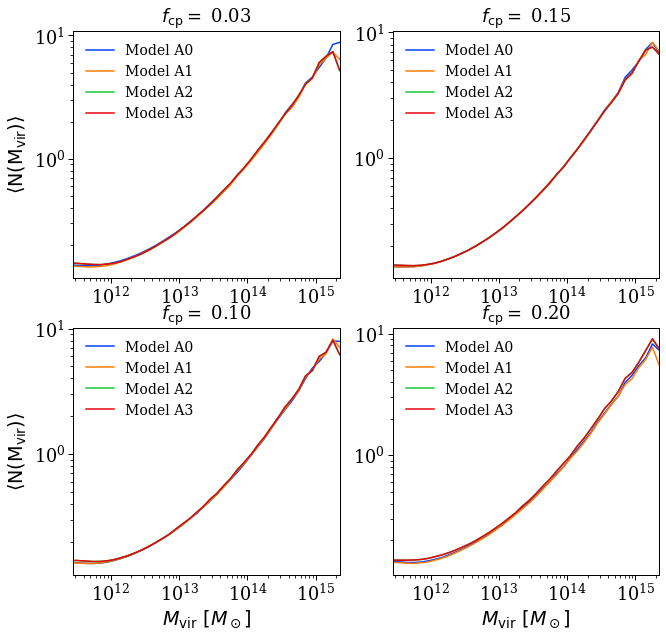

In [111]:
fig, ax = plt.subplots(2, 2, figsize=(10.5, 10 ))
zz = 3
print(z_bins[zz])
color = sns.color_palette("bright", histAGN_ALL.shape[0]+1)#['r', 'b', 'g', 'orange']
#--------------------------------#
f = 0
for m in range(len(model_names_arr)):
    label, title = 'Model A%d'%m, r'$f_{\rm cp}=$ %.2f'%frac_cp_arr[f]
    ax[0, 0] = plotForAllZbins(ax[0,0], m_mid, histAGN_ALL[m, f, :, zz]/cen_histGAL[:, zz],\
                         color[m], label=label)
pt.setLabel(ax[0, 0], '', r'$\langle \rm N(M_{\rm vir}) \rangle$', \
            xlim=[10**np.min(m_mid), 10**np.max(m_mid)], title=title)
#--------------------------------#
f = 1
for m in range(len(model_names_arr)):
    label, title = 'Model A%d'%m, r'$f_{\rm cp}=$ %.2f'%frac_cp_arr[f]
    ax[1, 0] = plotForAllZbins(ax[1,0], m_mid, histAGN_ALL[m, f, :, zz]/cen_histGAL[:, zz],\
                         color[m], label=label)
pt.setLabel(ax[1, 0], r'$M_{\rm vir}\ [M_\odot]$', r'$\langle \rm N(M_{\rm vir}) \rangle$',\
            xlim=[10**np.min(m_mid), 10**np.max(m_mid)], title=title)
#--------------------------------#
f = 2
for m in range(len(model_names_arr)):
    label, title = 'Model A%d'%m, r'$f_{\rm cp}=$ %.2f'%frac_cp_arr[f]
    ax[0, 1] = plotForAllZbins(ax[0,1], m_mid, histAGN_ALL[m, f, :, zz]/cen_histGAL[:, zz],\
                         color[m], label=label)
pt.setLabel(ax[0, 1], '', '',\
            xlim=[10**np.min(m_mid), 10**np.max(m_mid)], title=title)
#--------------------------------#
f = 3
for m in range(len(model_names_arr)):
    label, title = 'Model A%d'%m, r'$f_{\rm cp}=$ %.2f'%frac_cp_arr[f]
    ax[1, 1] = plotForAllZbins(ax[1, 1], m_mid, histAGN_ALL[m, f, :, zz]/cen_histGAL[:, zz],\
                         color[m], label=label)
pt.setLabel(ax[1, 1],r'$M_{\rm vir}\ [M_\odot]$', '',\
            xlim=[10**np.min(m_mid), 10**np.max(m_mid)], title=title)

for i, j in zip([0, 0, 1, 1], [0, 1, 0, 1]):
    ax[i, j].set_xscale('log')
    ax[i, j].set_yscale('log')
    
fig.patch.set_facecolor('white')
pt.saveFig('frac_fixed_models_changed.png')

0.30000000000000004


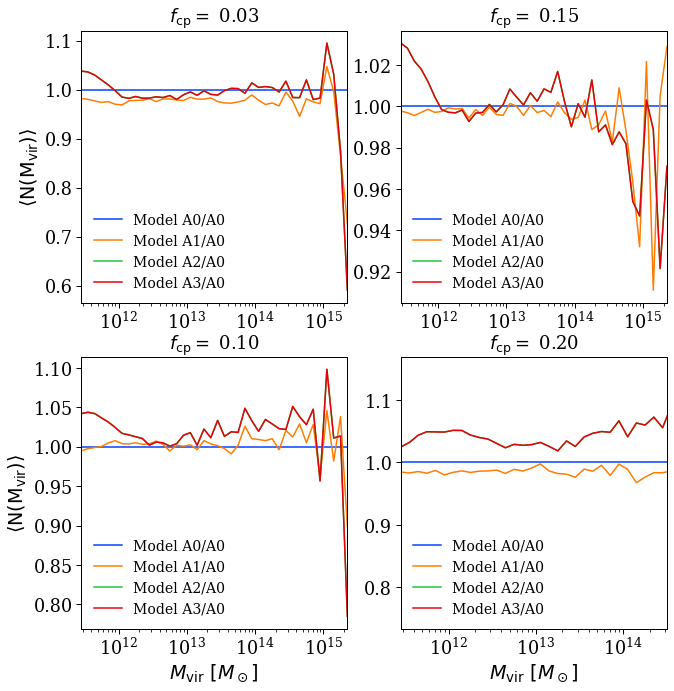

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(10.5, 11 ))
zz = 3
print(z_bins[zz])
color = sns.color_palette("bright", histAGN_ALL.shape[0]+1)#['r', 'b', 'g', 'orange']
#--------------------------------#
f = 0
hod0 = histAGN_ALL[0, f, :, zz]/cen_histGAL[:, zz]
for m in range(len(model_names_arr)):
    label, title = 'Model A%d/A0'%m, r'$f_{\rm cp}=$ %.2f'%frac_cp_arr[f]
    hod = histAGN_ALL[m, f, :, zz]/cen_histGAL[:, zz]
    ax[0, 0] = plotForAllZbins(ax[0,0], m_mid, hod/hod0,\
                         color[m], label=label)
pt.setLabel(ax[0, 0], '', r'$\langle \rm N(M_{\rm vir}) \rangle$', \
            xlim=[10**np.min(m_mid), 10**np.max(m_mid)], title=title)
#--------------------------------#
f = 1
hod0 = histAGN_ALL[0, f, :, zz]/cen_histGAL[:, zz]

for m in range(len(model_names_arr)):
    label, title = 'Model A%d/A0'%m, r'$f_{\rm cp}=$ %.2f'%frac_cp_arr[f]
    hod = histAGN_ALL[m, f, :, zz]/cen_histGAL[:, zz]
    ax[1, 0] = plotForAllZbins(ax[1,0], m_mid, hod/hod0,\
                         color[m], label=label)
pt.setLabel(ax[1, 0], r'$M_{\rm vir}\ [M_\odot]$', r'$\langle \rm N(M_{\rm vir}) \rangle$',\
            xlim=[10**np.min(m_mid), 10**np.max(m_mid)], title=title)
#--------------------------------#
f = 2
hod0 = histAGN_ALL[0, f, :, zz]/cen_histGAL[:, zz]

for m in range(len(model_names_arr)):
    label, title = 'Model A%d/A0'%m, r'$f_{\rm cp}=$ %.2f'%frac_cp_arr[f]
    hod = histAGN_ALL[m, f, :, zz]/cen_histGAL[:, zz]
    ax[0, 1] = plotForAllZbins(ax[0,1], m_mid, hod/hod0,\
                         color[m], label=label)
pt.setLabel(ax[0, 1], '', '',\
            xlim=[10**np.min(m_mid), 10**np.max(m_mid)], title=title)
#--------------------------------#
f = 3
hod0 = histAGN_ALL[0, f, :, zz]/cen_histGAL[:, zz]

for m in range(len(model_names_arr)):
    label, title = 'Model A%d/A0'%m, r'$f_{\rm cp}=$ %.2f'%frac_cp_arr[f]
    hod = histAGN_ALL[m, f, :, zz]/cen_histGAL[:, zz]
    ax[1, 1] = plotForAllZbins(ax[1, 1], m_mid, hod/hod0,\
                         color[m], label=label)
pt.setLabel(ax[1, 1],r'$M_{\rm vir}\ [M_\odot]$', '',\
            xlim=[10**np.min(m_mid), 10**14.5], title=title)

for i, j in zip([0, 0, 1, 1], [0, 1, 0, 1]):
    ax[i, j].set_xscale('log')

fig.patch.set_facecolor('white')
pt.saveFig('frac_fixed_relative_models_changed.png')

In [ ]:
z_mid[zz]

z = 0.8


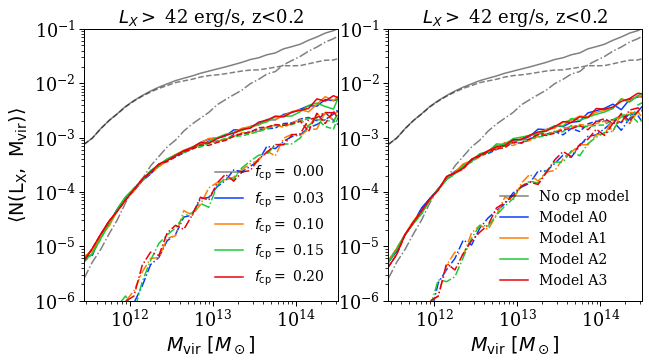

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
zz = 7
m_stop = 14.5
color = sns.color_palette("bright", histAGN_ALL.shape[0]+1)
ib.reload(hod)
Lmin, zmax = 42, 0.2
add2title= r'$L_X>$ %d erg/s, z<%.1f'%(Lmin, zmax)
ax0, ax1 = ax
ax0 = hod.plotOgHOD(ax0, m_mid, histAGN, cen_histAGN, cen_histGAL)
ax1 = hod.plotOgHOD(ax1, m_mid, histAGN, cen_histAGN, cen_histGAL, label='No cp model')
model_no = 1
# change fractions
# r'$f_{\rm cp}=$ %.2f, z = %.1f'%(frac_cp_arr[f],z_mid[zz])+'\n'+
title = add2title
ax0 = hod.plotFracFixedModels(ax0, frac_cp_arr, histAGN_ALL_L42, cen_histAGN_ALL_L42, cen_histGAL,\
                             m_mid, model_no=model_no)
pt.setLabel(ax[0], r'$M_{\rm vir}\ [M_\odot]$', r'$\langle \rm N(L_{X},\ M_{\rm vir}) \rangle$', \
                xlim=[10**np.min(m_mid), 10**m_stop], ylim=[10**(-6), 10**(-1)],title=title)

f = 3
# change models
# r'$f_{\rm cp}=$ %.2f, z = %.1f'%(frac_cp_arr[f],z_mid[zz])+'\n'+
title = add2title
ax1 = hod.plotModelsFixedFrac(ax1, model_names_arr, histAGN_ALL_L42, cen_histAGN_ALL_L42, cen_histGAL, m_mid,\
                        frac_cp=f)
    

pt.setLabel(ax[1],r'$M_{\rm vir}\ [M_\odot]$', '',\
            xlim=[10**np.min(m_mid), 10**m_stop], ylim=[10**(-6), 10**(-1)],title=title)

for i in [0, 1]:
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    
fig.patch.set_facecolor('white')
print('z = %.1f'%z_mid[zz])
pt.saveFig('frac_fixed_models_fixed_z%.1f_Lx'%z_mid[zz]+str(Lmin)+'.png')

z = 0.8


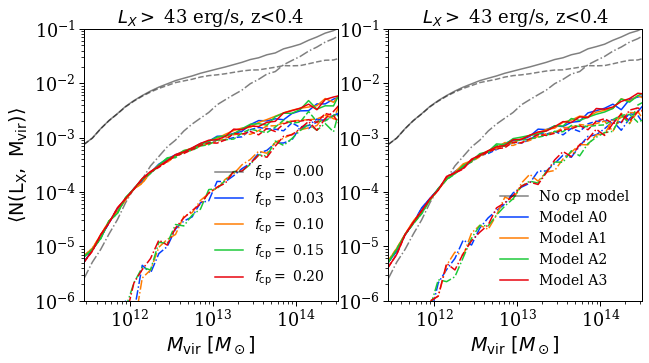

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
zz = 7
m_stop = 14.5
Lmin, zmax = 43, 0.4
color = sns.color_palette("bright", histAGN_ALL.shape[0]+1)
add2title= r'$L_X>$ %d erg/s, z<%.1f'%(Lmin, zmax)
ib.reload(hod)

ax0, ax1 = ax
ax0 = hod.plotOgHOD(ax0, m_mid, histAGN, cen_histAGN, cen_histGAL)
ax1 = hod.plotOgHOD(ax1, m_mid, histAGN, cen_histAGN, cen_histGAL, label='No cp model')

model_no = 1
# change fractions
# r'$f_{\rm cp}=$ %.2f, z = %.1f'%(frac_cp_arr[f],z_mid[zz])+'\n'+
title = add2title
ax0 = hod.plotFracFixedModels(ax0, frac_cp_arr, histAGN_ALL_L43, cen_histAGN_ALL_L43, cen_histGAL,\
                             m_mid, model_no=0)
pt.setLabel(ax[0], r'$M_{\rm vir}\ [M_\odot]$', r'$\langle \rm N(L_{X},\ M_{\rm vir}) \rangle$', \
                xlim=[10**np.min(m_mid), 10**m_stop], ylim=[10**(-6), 10**(-1)],title=title)


f = 3
# change models
# r'$f_{\rm cp}=$ %.2f, z = %.1f'%(frac_cp_arr[f],z_mid[zz])+'\n'+
title = add2title
ax1 = hod.plotModelsFixedFrac(ax1, model_names_arr, histAGN_ALL_L43, cen_histAGN_ALL_L43, cen_histGAL, m_mid,\
                        frac_cp=f)
    

pt.setLabel(ax[1],r'$M_{\rm vir}\ [M_\odot]$', '',\
            xlim=[10**np.min(m_mid), 10**m_stop], ylim=[10**(-6), 10**(-1)],title=title)


for i in [0, 1]:
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    
fig.patch.set_facecolor('white')
print('z = %.1f'%z_mid[zz])
pt.saveFig('frac_fixed_models_fixed_z%.1f_Lx'%z_mid[zz]+str(Lmin)+'.png')

In [29]:
histAGN[0, 0]-histAGN_ALL_L44[0, 0, 0]

array([1471., 1471., 1467., 1455., 1430., 1375., 1305., 1115.,  880.,
        488.,   42., 1471., 1471., 1471., 1471., 1471., 1471., 1471.,
       1471., 1471., 1471.])

z = 0.8


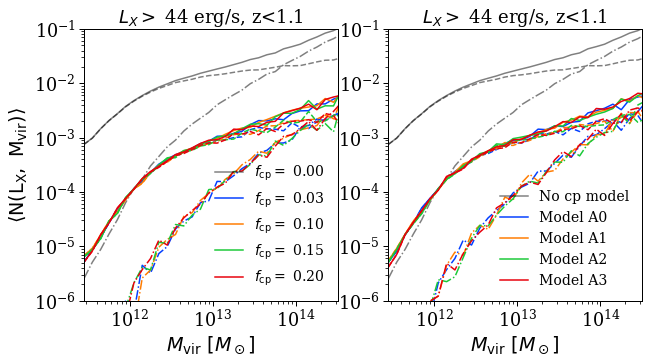

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
zz = 7
m_stop = 14.5
Lmin, zmax = 44, 1.1
color = sns.color_palette("bright", histAGN_ALL.shape[0]+1)
add2title= r'$L_X>$ %d erg/s, z<%.1f'%(Lmin, zmax)

ib.reload(hod)

ax0, ax1 = ax
ax0 = hod.plotOgHOD(ax0, m_mid, histAGN, cen_histAGN, cen_histGAL)
ax1 = hod.plotOgHOD(ax1, m_mid, histAGN, cen_histAGN, cen_histGAL, label='No cp model')

model_no = 1
# change fractions
#title = r'Model A%d, z = %.1f'%(model_no, z_mid[zz])+'\n'+add2title
# r'$f_{\rm cp}=$ %.2f, z = %.1f'%(frac_cp_arr[f],z_mid[zz])+'\n'+
title = add2title
ax0 = hod.plotFracFixedModels(ax0, frac_cp_arr, histAGN_ALL_L44, cen_histAGN_ALL_L44, cen_histGAL,\
                             m_mid, model_no=0)
pt.setLabel(ax[0], r'$M_{\rm vir}\ [M_\odot]$', r'$\langle \rm N(L_{X},\ M_{\rm vir}) \rangle$', \
                xlim=[10**np.min(m_mid), 10**m_stop], ylim=[10**(-6), 10**(-1)],title=title)

f = 3
# change models
#title = r'$f_{\rm cp}=$ %.2f, z = %.1f'%(frac_cp_arr[f],z_mid[zz])+'\n'+add2title
# r'$f_{\rm cp}=$ %.2f, z = %.1f'%(frac_cp_arr[f],z_mid[zz])+'\n'+
title = add2title
ax1 = hod.plotModelsFixedFrac(ax1, model_names_arr, histAGN_ALL_L44, cen_histAGN_ALL_L44, cen_histGAL, m_mid,\
                        frac_cp=f)
    

pt.setLabel(ax[1],r'$M_{\rm vir}\ [M_\odot]$', '',\
            xlim=[10**np.min(m_mid), 10**m_stop], ylim=[10**(-6), 10**(-1)],title=title)

for i in [0, 1]:
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    
fig.patch.set_facecolor('white')
print('z = %.1f'%z_mid[zz])
pt.saveFig('frac_fixed_models_fixed_z%.1f_Lx'%z_mid[zz]+str(Lmin)+'.png')

/home/shreeram/miniconda3/envs/eroconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/home/shreeram/miniconda3/envs/eroconda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/home/shreeram/miniconda3/envs/eroconda/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/home/shreeram/miniconda3/envs/eroconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/home/shreeram/miniconda3/envs/eroconda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/home/shreeram/miniconda3/envs/eroconda/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0

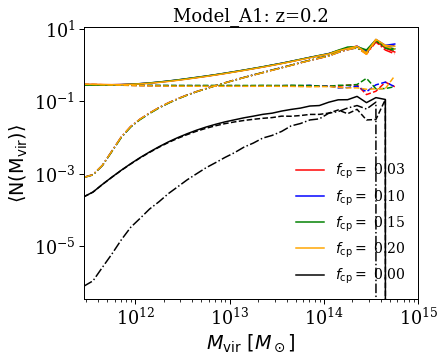

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
color = ['r', 'b', 'g', 'orange']
model_no = 1
for f in range(len(frac_cp_arr)):
    label = r'$f_{\rm cp}=$ %.2f'%frac_cp_arr[f]
    ax = plotForAllZbins(ax, m_mid, histAGN_ALL[model_no, f, :, zz]/cen_histGAL[:, zz],\
                         color[f], label=label)
    
    ax = plotForAllZbins(ax, m_mid, cen_histAGN_ALL[model_no, f, :, zz]/cen_histGAL[:, zz],\
                         color[f], ls='--')
    
    sat_AGN_model = histAGN_ALL[model_no, f, :, zz]-cen_histAGN_ALL[model_no, f, :, zz]
    ax = plotForAllZbins(ax, m_mid, sat_AGN_model/cen_histGAL[:, zz],\
                         color[f], ls='-.')

ax.plot(10**m_mid, histAGN[:, zz]/cen_histGAL[:, zz], 'k-', lw=1.5, label=r'$f_{\rm cp}=$ 0.00')
ax.plot(10**m_mid, cen_histAGN[:, zz]/cen_histGAL[:, zz], 'k--', lw=1.5)
ax.plot(10**m_mid, (histAGN[:, zz]-cen_histAGN[:, zz])/cen_histGAL[:, zz], 'k-.', lw=1.5)

ax.set_yscale('log')
ax.set_xscale('log')
fig.patch.set_facecolor('white')
lim = 15
pt.setLabel(ax, r'$M_{\rm vir}\ [M_\odot]$', r'$\langle \rm N(M_{\rm vir}) \rangle$',\
            legend=True, xlim=[10**np.min(m_mid), 10**lim],\
            title='Model_A%d: '%model_no+'z=%.1f'%z_mid[i])

pt.saveFig('frac_cp_HOD_different_fcp.png')

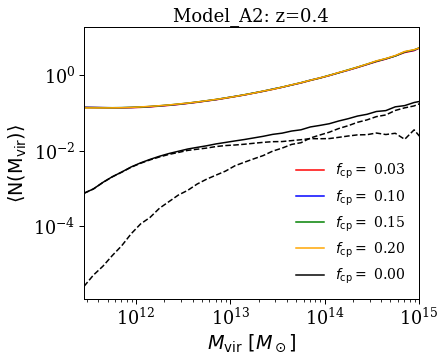

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
color = ['r', 'b', 'g', 'orange']
model_no = 2

for f in range(len(frac_cp_arr)):
    label = r'$f_{\rm cp}=$ %.2f'%frac_cp_arr[f]
    ax = plotForAllZbins(ax, m_mid, histAGN_ALL[model_no, f, :, zz]/cen_histGAL[:, zz],\
                         color[f], label=label)

ax.plot(10**m_mid, histAGN[:, zz]/cen_histGAL[:, zz], 'k-', lw=1.5, label=r'$f_{\rm cp}=$ 0.00')
ax.plot(10**m_mid, cen_histAGN[:, zz]/cen_histGAL[:, zz], 'k--', lw=1.5)
ax.plot(10**m_mid, (histAGN[:, zz]-cen_histAGN[:, zz])/cen_histGAL[:, zz], 'k--', lw=1.5)

ax.set_yscale('log')
ax.set_xscale('log')
fig.patch.set_facecolor('white')
pt.setLabel(ax, r'$M_{\rm vir}\ [M_\odot]$', r'$\langle \rm N(M_{\rm vir}) \rangle$',\
            legend=True, xlim=[10**np.min(m_mid), 10**15],\
            title='Model_A%d: '%model_no+'z=%.1f'%z_mid[zz])

pt.saveFig('frac_cp_HOD_different_fcp_withoutAGN.png')

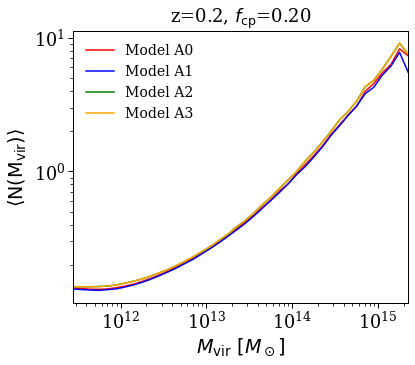

In [105]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
color = ['r', 'b', 'g', 'orange']
f = 3

for m in range(len(model_names_arr)):
    label = 'Model A%d'%m
    ax = plotForAllZbins(ax, m_mid, histAGN_ALL[m, f, :, zz]/cen_histGAL[:, zz],\
                         color[m], label=label)
#ax.plot(10**m_mid, histAGN[:, zz]/cen_histGAL[:, zz], 'k', lw=1.5, label=r'$f_{\rm cp}=$ 0')

ax.set_yscale('log')
ax.set_xscale('log')
fig.patch.set_facecolor('white')
pt.setLabel(ax, r'$M_{\rm vir}\ [M_\odot]$', r'$\langle \rm N(M_{\rm vir}) \rangle$',\
            legend=True, xlim=[10**np.min(m_mid), 10**np.max(m_mid)],\
            title='z=%.1f, '%z_mid[i]+r'$f_{\rm cp}$=%.2f'%frac_cp_arr[f])

pt.saveFig('frac_cp_HOD_different_models.png')

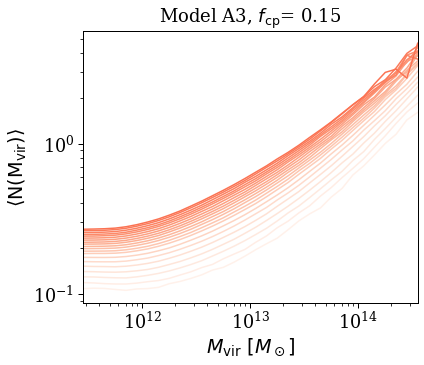

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
reds = sns.color_palette("Reds", cen_histAGN_ALL.shape[2]+1)
greys = sns.color_palette("Greys", cen_histAGN_ALL.shape[2]+1)
model_no = 3
f = 2
stop_m = -8
for zz in range(len(z_bins[cut_columns])):
    label = r'$f_{\rm cp}=$ %.2f'%frac_cp_arr[f]
    ax = plotForAllZbins(ax, m_mid[:stop_m], histAGN_ALL[model_no, f, :stop_m, zz]/cen_histGAL[:stop_m, zz],\
                         reds[zz], label=label)

ax.set_yscale('log')
ax.set_xscale('log')
fig.patch.set_facecolor('white')
pt.setLabel(ax, r'$M_{\rm vir}\ [M_\odot]$', r'$\langle \rm N(M_{\rm vir}) \rangle$',\
            legend=False, xlim=[10**np.min(m_mid), 10**np.max(m_mid[:stop_m])], \
           title=r'Model A%d, $f_{\rm cp}$= %.2f'%(model_no, frac_cp_arr[f]) )